In [16]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats
import xarray as xr

NPIX = 10

rc("font", **{"family": "Times"})
rc("text", usetex=True)
# plt.rcParams['figure.dpi']= 300
plt.rcParams['figure.dpi']= 150

test = torch.from_numpy(xr.open_dataset("test.nc").pr.values.reshape(-1, 1, NPIX, 64, 64))
samples = torch.load("samples.pt", map_location=torch.device('cpu'))

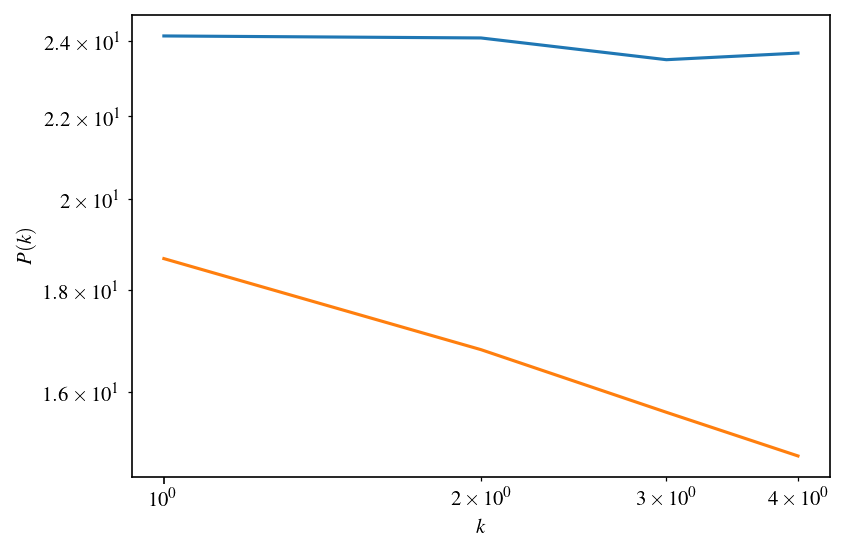

In [17]:
def psd_temporal(frames):
    pixels_in_time = frames.reshape(frames.shape[0], NPIX, -1).transpose(1, 2).reshape(-1, NPIX)

    fourier_image = np.fft.fftn(pixels_in_time, axes = (1,))
    fourier_amplitudes = np.abs(fourier_image) ** 2

    kfreq = np.fft.fftfreq(NPIX) * NPIX

    kbins = np.arange(0.5, NPIX // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic( 
        kfreq, # Need to check this
        fourier_amplitudes,
        statistic = "mean",
        bins = kbins
    )
    Abins *= np.pi * (kbins[1:] ** 2 - kbins[:-1] ** 2)
    Abins = np.mean(Abins, axis = 0)

    return kvals, Abins

kvals_test, Abins_test = psd_temporal(test)
kvals_sample, Abins_sample = psd_temporal(samples)

plt.figure(figsize=(6, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample, Abins_sample, label="Generated")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.show()